# Study overlap

In [1]:
import uproot
import pandas as pd
import numpy as np
from HH4b.utils import load_samples, format_columns

Load samples from Resolved group

In [2]:
# dir = "../../../../data/overlap/Main_PNet_MinDiag_w4j35_w2bj30_dHHjw30_withoutSyst_25April2024_2022_0L/mc/parts/"
dir = "/Users/daniel/Documents/UCSD/Research/HH4b"
samples = {
    "hh4b": "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8_tree.root",
}

ak8_columns = [
    "ak8_pt",
    "ak8_eta",
    "ak8_phi",
    "ak8_jetId",
    "ak8_msoftdrop",
    "ak8_mass",
    "ak8_tau3",
    "ak8_tau2",
    "ak8_Txbb",
    "ak8_PQCDb",
    "ak8_PQCDbb",
    "ak8_PQCDothers",
    "ak8_particleNet_mass",
    # "met", #is this the right spot to add?
]

columns_to_load_resolved = [
    "passmetfilters",
    "passjetvetomap",
    "passTrig_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65",
    "passL1unprescaled_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65",
    "passTrigObjMatching_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65",
    "avgbdisc_twoldgbdiscjets",
    "alljets_ht",
    "dHH_NbtagM",
    "dHH_H1_regmass",
    "dHH_H2_regmass",
    "event",
    "lumiwgt",  # luminosity in fb 26.6717 for 2022EE
    "xsecWeight",  #  xsec * 1000 / sum('genEventSumw'), xsec in pb
    "genWeight",
    "puWeight",
    "trgSF_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65_central",
    "btagSF_central",
    "passTrig_HLT_AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35",
    "passTrig_HLT_AK8PFJet425_SoftDropMass40",
]
columns_to_load_boosted = columns_to_load_resolved + [
    "n_ak8",
    "ak8_pt",
    "ak8_eta",
    "ak8_phi",
    "ak8_jetId",
    "ak8_msoftdrop",
    "ak8_mass",
    "ak8_tau3",
    "ak8_tau2",
    "ak8_Txbb",
    "ak8_PQCDb",
    "ak8_PQCDbb",
    "ak8_PQCDothers",
    "ak8_particleNet_mass",
    "pass_resolved_skim",  # trigger & >=4 jets with some pt cuts and >= 2 bjets above 30 GeV
    "pass_boosted_skim",  # trigger & >=2  tight AK8 jets with pT > 250 GeV and |eta|<2.4
    "met",
]

"""
    2b: dHH_NbtagM == 2
    4b: dHH_NbtagM == 4
    asr_4b: ASR_4b
    asr_2b: ASR_2b
    acr_4b: ACR_4b
    acr_2b: ACR_2b
    vsr_4b: VSR_4b
    vsr_2b: VSR_2b
    vcr_4b: VCR_4b
    vcr_2b: VCR_2b
"""


def get_resolved_masks(df):
    regions = {}
    regions["RES"] = (
        (df["passTrig_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65"])
        & (df["passL1unprescaled_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65"])
        & (df["passTrigObjMatching_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65"])
        & (df["passmetfilters"])
        & (df["passjetvetomap"])
        & (df["avgbdisc_twoldgbdiscjets"] > 0.65)
        & (df["alljets_ht"] > 0)
    )

    # Calculate variables
    # df['AR_dHM'] = np.sqrt((df['dHH_H1_regmass'] - 125)**2 + (df['dHH_H2_regmass'] - 120)**2)
    # df['VR_dHM'] = np.sqrt((df['dHH_H1_regmass'] - 185)**2 + (df['dHH_H2_regmass'] - 182)**2)
    # Define additional regions based on these variables
    # df['ASR_4b'] = (df['AR_dHM'] < 30) & (df['dHH_NbtagM'] == 4)
    # df['ACR_4b'] = (df['AR_dHM'] >= 30) & (df['AR_dHM'] < 55) & (df['dHH_NbtagM'] == 4)
    # df['VSR_4b'] = (df['VR_dHM'] < 30) & (df['dHH_NbtagM'] == 4)
    # df['VCR_4b'] = (df['VR_dHM'] >= 30) & (df['VR_dHM'] < 55) & (df['dHH_NbtagM'] == 4)

    df["dHiggsDeltaRegMass"] = np.sqrt(
        ((df["dHH_H1_regmass"] - 125.0) * (df["dHH_H1_regmass"] - 125.0))
        + ((df["dHH_H2_regmass"] - 120.0) * (df["dHH_H2_regmass"] - 120.0))
    )

    regions = {
        **regions,
        "RES4b": (regions["RES"] & (df["dHH_NbtagM"] == 4)),
        "RES4bSR": (regions["RES"] & (df["dHiggsDeltaRegMass"] < 30.0) & (df["dHH_NbtagM"] == 4)),
    }

    return regions


for sample, sample_file in samples.items():
    print(f"{dir}/{sample_file}")
    tree = uproot.open(f"{dir}/{sample_file}:Events")
    print("Number of raw events: ", len(tree.arrays(["event"])["event"]))
    #########################################
    # Load resolved data as a pandas DataFrame
    df = tree.arrays(columns_to_load_resolved, library="pd")
    print("Number of resolved dataframe entries: ", len(df["event"]))

    # Weights
    df["resolved_weight"] = (
        df["lumiwgt"]
        * df["xsecWeight"]
        * df["genWeight"]
        * df["puWeight"]
        * df["trgSF_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65_central"]
        * df["btagSF_central"]
    )

    # Define resolved regions
    regions = get_resolved_masks(df)

    # Get resolved yields and counts
    resolved_yields = {
        region: [np.sum(df["resolved_weight"][region_mask])]
        for region, region_mask in regions.items()
    }
    resolved_counts = {
        region: int(df["event"][region_mask].shape[0]) for region, region_mask in regions.items()
    }

    #########################################
    # Load boosted data as a pandas DataFrame
    df_b = tree.arrays(columns_to_load_boosted, library="pd")
    # Ask for at least 2 ak8 jets in boosted pandas dataframe
    df_b = df_b[
        (df_b["n_ak8"] >= 2)
        & (df_b["passmetfilters"])
        & (df_b["passjetvetomap"])
        & (
            (df_b["passTrig_HLT_AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35"])
            | (df_b["passTrig_HLT_AK8PFJet425_SoftDropMass40"])
        )
    ].copy()
    print("Number of boosted dataframe entries: ", len(df_b["event"]))

    # Add weights
    df_b["boosted_weight"] = (
        df_b["lumiwgt"] * df_b["xsecWeight"] * df_b["genWeight"] * df_b["puWeight"]
    )
    df_b["resolved_weight"] = (
        df_b["lumiwgt"]
        * df_b["xsecWeight"]
        * df_b["genWeight"]
        * df_b["puWeight"]
        * df_b["trgSF_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65_central"]
        * df_b["btagSF_central"]
    )

    # Order jets by fatjet Xbb
    df_ak8 = df_b.reset_index()
    df_ak8 = df_ak8.sort_values(by=["entry", "ak8_Txbb"], ascending=[True, False]).set_index(
        ["entry", "subentry"]
    )
    subindex = df_ak8.sort_index().index.get_level_values(1)
    df_ak8 = df_ak8.reset_index()
    df_ak8["subentry"] = subindex
    df_ak8 = df_ak8.set_index(["entry", "subentry"])

    # For boosted, yields must be obtained for one of the entries
    jet0 = df_ak8.query("subentry == 0")
    jet1 = df_ak8.query("subentry == 1")

    # Define resolved regions for this dataframe
    resolved_regions = {
        **{f"BST-{region}": region_mask for region, region_mask in get_resolved_masks(jet0).items()}
    }

    # NOTE!!!: you must use .to_numpy() to get the masks with jet0 otherwise you cannot do an OR
    boosted_regions = {
        "BST30060-X0bb08": (
            (jet0["ak8_pt"] >= 300).to_numpy()
            & (jet1["ak8_pt"] >= 300).to_numpy()
            & (jet0["ak8_msoftdrop"] >= 60).to_numpy()
            & (jet1["ak8_msoftdrop"] >= 60).to_numpy()
            & (jet0["ak8_Txbb"] >= 0.8).to_numpy()
        ),
        "BST25060-X0bb08": (
            (jet0["ak8_pt"] >= 250).to_numpy()
            & (jet1["ak8_pt"] >= 250).to_numpy()
            & (jet0["ak8_msoftdrop"] >= 60).to_numpy()
            & (jet1["ak8_msoftdrop"] >= 60).to_numpy()
            & (jet0["ak8_Txbb"] >= 0.8).to_numpy()
        ),
    }

    # compute overlap
    overlap_regions = {
        "RES4b-BST30060-X0bb08": (
            resolved_regions["BST-RES4b"] & boosted_regions["BST30060-X0bb08"]
        ),
    }

    boosted_yields = {
        region: [np.sum(jet0["boosted_weight"][region_mask])]
        for region, region_mask in boosted_regions.items()
    }
    boosted_counts = {
        region: int(jet0["event"][region_mask].shape[0])
        for region, region_mask in boosted_regions.items()
    }

    overlap_yields = {
        region: [np.sum(jet0["resolved_weight"][region_mask])]
        for region, region_mask in overlap_regions.items()
    }
    overlap_counts = {
        region: int(jet0["event"][region_mask].shape[0])
        for region, region_mask in overlap_regions.items()
    }

    # make yields and  counts dataframe
    df_yields = pd.DataFrame(
        {
            "sample": "hh4b",
            **resolved_yields,
            **boosted_yields,
            **overlap_yields,
        }
    )

    df_counts = pd.DataFrame(
        {
            "sample": "hh4b",
            "all": int(df["event"].shape[0]),
            **resolved_counts,
            **boosted_counts,
            **overlap_counts,
        },
        index=[0],
    )

/Users/daniel/Documents/UCSD/Research/HH4b/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8_tree.root
Number of raw events:  2377354
Number of resolved dataframe entries:  2377354


/Users/daniel/mambaforge/envs/hh4b/lib/python3.9/site-packages/uproot/interpretation/library.py:747: FutureWarning: MultiIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if hasattr(index, "is_integer") and index.is_integer():


Number of boosted dataframe entries:  571933


/var/folders/w8/jgj1y4sx0mg8849sgcwfdfgh0000gn/T/ipykernel_44845/1805845227.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dHiggsDeltaRegMass"] = np.sqrt(


In [3]:
print(df_yields.to_markdown())  # percentage here

|    | sample   |     RES |   RES4b |   RES4bSR |   BST30060-X0bb08 |   BST25060-X0bb08 |   RES4b-BST30060-X0bb08 |
|---:|:---------|--------:|--------:|----------:|------------------:|------------------:|------------------------:|
|  0 | hh4b     | 68.2276 | 19.9474 |   13.2769 |            3.0976 |           4.15524 |                 1.22037 |


In [4]:
print(df_counts.to_markdown())

|    | sample   |     all |     RES |   RES4b |   RES4bSR |   BST30060-X0bb08 |   BST25060-X0bb08 |   RES4b-BST30060-X0bb08 |
|---:|:---------|--------:|--------:|--------:|----------:|------------------:|------------------:|------------------------:|
|  0 | hh4b     | 2377354 | 1741977 |  559983 |    385524 |             85355 |            113998 |                   39097 |


In [5]:
np.any(df["genWeight"] < 0)

True

Cross check yield with boosted ntuples

In [6]:
"""
year = "2022EE"

sample_dirs = {
    f"../../../../data/skimmer/24Apr23LegacyLowerThresholds_v12_private_signal/": {
        "hh4b_v12_private": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV"],
    },
}

load_columns = [
    ("bbFatJetPNetTXbbLegacy", 2),
    ("bbFatJetPNetMassLegacy", 2),
    ("bbFatJetPNetTXbb", 2),
    ("bbFatJetPNetMass", 2),
    ("bbFatJetMsd", 2),
    ("bbFatJetPt", 2),
    ("weight", 1),
    ("trigger_sf", 1),
    ("AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35", 1),
    ("AK8PFJet425_SoftDropMass40", 1),
]

events_dict = {}
for input_dir, samples_dict in sample_dirs.items():
    print(input_dir)
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **load_samples(
            input_dir,
            samples_dict,
            year,
            variations=False,
            columns=format_columns(load_columns),
            reorder_legacy_txbb=True,
        ),
    }


for key in ["hh4b_v12_private"]:
    print(key)
    events = events_dict[key]

    boosted_mask = (
        (events["bbFatJetPt"][0] > 300)
        & (events["bbFatJetPt"][1] > 300)
        & (events["bbFatJetPNetTXbb"][0] > 0.8)
        & (events["bbFatJetMsd"][0] > 60)
        & (events["bbFatJetMsd"][1] > 60)
        & np.any(
            [
                events["AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35"],
                events["AK8PFJet425_SoftDropMass40"],
            ]
        )
    )
    print(np.sum(events["finalWeight"][boosted_mask]), len(events["finalWeight"][boosted_mask]))
    """

'\nyear = "2022EE"\n\nsample_dirs = {\n    f"../../../../data/skimmer/24Apr23LegacyLowerThresholds_v12_private_signal/": {\n        "hh4b_v12_private": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV"],\n    },\n}\n\nload_columns = [\n    ("bbFatJetPNetTXbbLegacy", 2),\n    ("bbFatJetPNetMassLegacy", 2),\n    ("bbFatJetPNetTXbb", 2),\n    ("bbFatJetPNetMass", 2),\n    ("bbFatJetMsd", 2),\n    ("bbFatJetPt", 2),\n    ("weight", 1),\n    ("trigger_sf", 1),\n    ("AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35", 1),\n    ("AK8PFJet425_SoftDropMass40", 1),\n]\n\nevents_dict = {}\nfor input_dir, samples_dict in sample_dirs.items():\n    print(input_dir)\n    events_dict = {\n        **events_dict,\n        # this function will load files (only the columns selected), apply filters and compute a weight per event\n        **load_samples(\n            input_dir,\n            samples_dict,\n            year,\n            variations=False,\n            columns=format_columns(load_colu

In [7]:
# events["weight"]

2.0.3


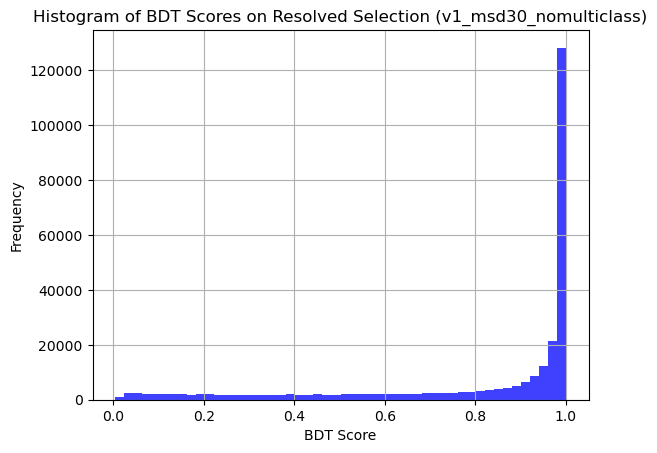

In [17]:
# run inference

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

model_path = '"/Users/daniel/Documents/UCSD/Research/HH4b/src/HH4b/boosted/bdt_trainings_run3/v1_msd30_nomulticlass'
print(xgb.__version__)
# Load Model
bdt_model_name = "v1_msd30_nomulticlass"
bdt_config = "v1_msd30"
bdt_model = XGBClassifier()
bdt_model.load_model(fname=f"../boosted/bdt_trainings_run3/{bdt_model_name}/trained_bdt.model")

from resolved_config import bdt_dataframe_resolved

# prepare data
# dtest = bdt_dataframe_resolved(df[df_ak8])
dtest = bdt_dataframe_resolved(df_ak8)
y_test = np.ones(len(dtest))

# Make predictions
predictions = bdt_model.predict(dtest)
probabilities = bdt_model.predict_proba(dtest)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
# roc_auc = roc_auc_score(y_test, predictions)

import matplotlib.pyplot as plt

plt.hist(probabilities[:, 0], bins=50, alpha=0.75, color="blue")
plt.xlabel("BDT Score")
plt.ylabel("Frequency")
plt.title("Histogram of BDT Scores on Resolved Selection (v1_msd30_nomulticlass)")
plt.grid(True)
plt.show()

In [16]:
probabilities[:, 0]

array([0.9829435 , 0.99216366, 0.9991567 , ..., 0.999744  , 0.72120535,
       0.999229  ], dtype=float32)

In [ ]:
tree = uproot.open(f"{dir}/{sample_file}:Events")
tree.keys()

['run',
 'luminosityBlock',
 'event',
 'bunchCrossing',
 'genWeight',
 'nLHEScaleWeight',
 'LHEScaleWeight',
 'nPSWeight',
 'PSWeight',
 'LHE_Vpt',
 'genTtbarId',
 'PV_npvs',
 'L1_HTT280er',
 'L1_HTT280er_QuadJet_70_55_40_35_er2p5',
 'L1_HTT320er',
 'L1_HTT320er_QuadJet_70_55_40_40_er2p5',
 'L1_HTT320er_QuadJet_80_60_er2p1_45_40_er2p3',
 'L1_HTT320er_QuadJet_80_60_er2p1_50_45_er2p3',
 'L1_HTT360er',
 'L1_Mu6_HTT240er',
 'L1_QuadJet60er2p5',
 'HLT_IsoMu24',
 'HLT_IsoMu27',
 'HLT_Mu50',
 'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
 'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
 'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ_QuadPFJet70_50_40_30',
 'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ_QuadPFJet70_50_40_30_PFBTagParticleNet_2BTagSum0p65',
 'year',
 'channel',
 'lumiwgt',
 'passmetfilters',
 'passjetvetomap',
 'pass_boosted_skim',
 'pass_resolved_skim',
 'passTrigExtended',
 'passTrig_HLT_QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65',
 'passL1prescaled_

In [ ]:
# jet0['met']
df_ak8["met"][:, 0]
# do inference: get BDT score as array , make hist of array

entry
5          55.593925
31         11.982376
33         25.996336
42         11.023948
43         51.707699
             ...    
2377310    48.420010
2377316    18.014776
2377320    39.878395
2377331     6.260431
2377335    94.267067
Name: met, Length: 279277, dtype: float32